# Import Libraries

In [119]:
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision import models
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Preparing and exploring the dataset

In [120]:
dataset = CIFAR10(root='traindata/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='testdata/', train=False, transform=ToTensor())

Files already downloaded and verified


In [121]:
classes = dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [122]:
def visualize(testdataset):    
    i=10 #Test the dataset
    img, label = testdataset[i]
    plt.imshow(img.permute((1, 2, 0)))
    print('Label (numeric):', label)
    print('Label (textual):', classes[label])

Label (numeric): 4
Label (textual): deer


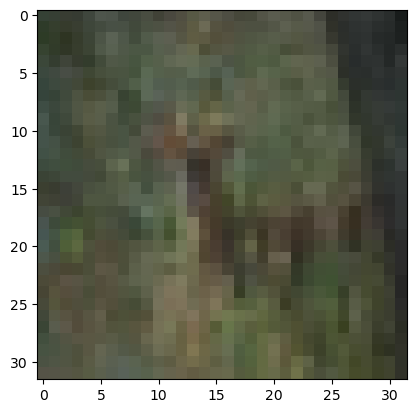

In [123]:
visualize(dataset)

In [124]:
class_count = {}
for _, index in dataset:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
class_count

{'frog': 5000,
 'truck': 5000,
 'deer': 5000,
 'automobile': 5000,
 'bird': 5000,
 'horse': 5000,
 'ship': 5000,
 'cat': 5000,
 'dog': 5000,
 'airplane': 5000}

In [125]:
torch.manual_seed(43)
val_size = 5000
train_size = len(dataset) - val_size

In [126]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [127]:
batch_size=128

In [128]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 3, 32, 32])


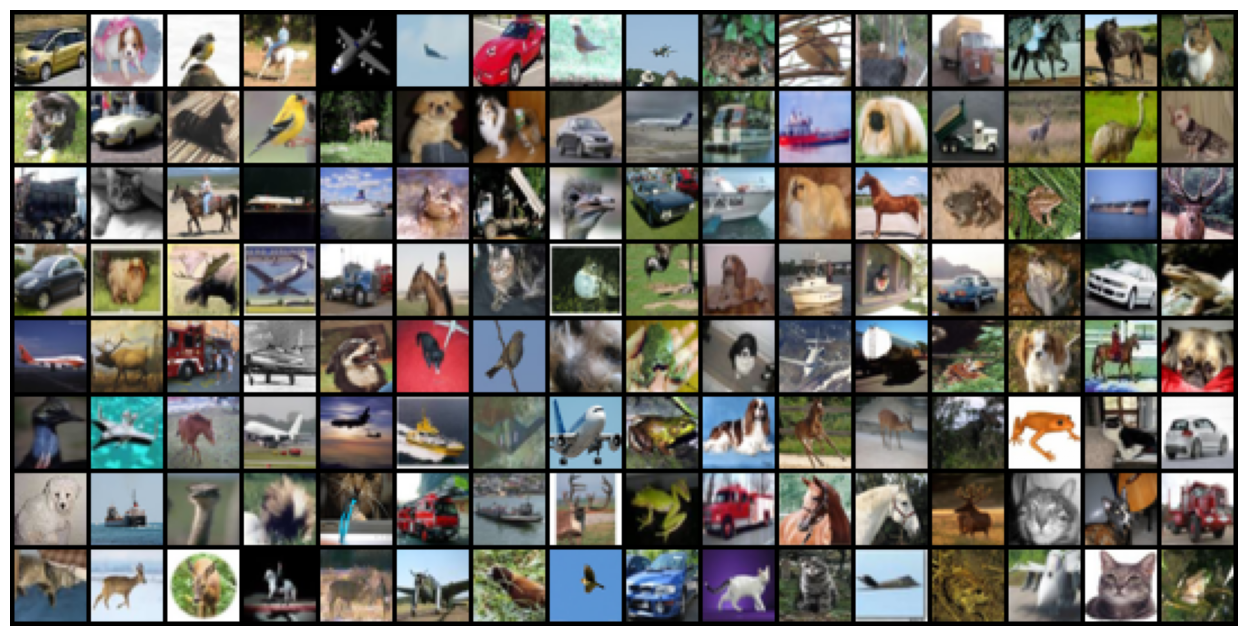

In [129]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

# Create Neural Network

In [130]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [131]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [132]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# Using a GPU in processing data

In [133]:
torch.cuda.is_available()

True

In [134]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [135]:
device = get_default_device()
device

device(type='cuda')

In [136]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [137]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [138]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [139]:
test_dl = test_loader
test_dl

In [219]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [225]:
train = train_loader.__iter__()
train.shape()

AttributeError: 'generator' object has no attribute 'shape'

# Model training

In [142]:
input_size = 3*32*32
output_size = 10

In [143]:
class CIFAR10Model0(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        return out

In [144]:
class CIFAR10Model1(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 4096)
        self.linear2 = nn.Linear(4096, 2048)
        self.linear3 = nn.Linear(2048, 512)
        self.linear4 = nn.Linear(512, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        return out

In [145]:
class CIFAR10Model2(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128, 64)
        self.linear5 = nn.Linear(64, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        return out

# Visualization of images

In [146]:
num_images_to_show = 3
test_images, test_labels = next(iter(test_dl))
test_images, test_labels = test_images.to(device), test_labels.to(device)

def visualize_output(model, model_name):
    model.eval()
    with torch.no_grad():
        model_outputs = model(test_images)

    _, predicted_classes = torch.max(model_outputs, 1)

    plt.figure(figsize=(12, 10))
    for i in range(num_images_to_show):
        plt.subplot(num_images_to_show, 1, i+1)
        image = test_images[i].cpu().numpy()
        image = np.transpose(image, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        image = image * 0.5 + 0.5  # Denormalize image
        plt.imshow(image)
        plt.title(f'Pred: {classes[predicted_classes[i]]}, True: {classes[test_labels[i]]}')
        plt.axis('off')
    plt.suptitle(f'{model_name} Model - Output for Test Images', y=1.02)
    plt.tight_layout()

In [147]:
model0 = to_device(CIFAR10Model0(), device)
model0

CIFAR10Model0(
  (linear1): Linear(in_features=3072, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=10, bias=True)
)

In [148]:
model1 = to_device(CIFAR10Model1(), device)
model1

CIFAR10Model1(
  (linear1): Linear(in_features=3072, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=2048, bias=True)
  (linear3): Linear(in_features=2048, out_features=512, bias=True)
  (linear4): Linear(in_features=512, out_features=10, bias=True)
)

In [149]:
model2 = to_device(CIFAR10Model2(), device)
model2

CIFAR10Model2(
  (linear1): Linear(in_features=3072, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=128, bias=True)
  (linear4): Linear(in_features=128, out_features=64, bias=True)
  (linear5): Linear(in_features=64, out_features=10, bias=True)
)

In [150]:
history0 = [evaluate(model0, val_loader)]
history0

[{'val_loss': 2.304347515106201, 'val_acc': 0.10464154183864594}]

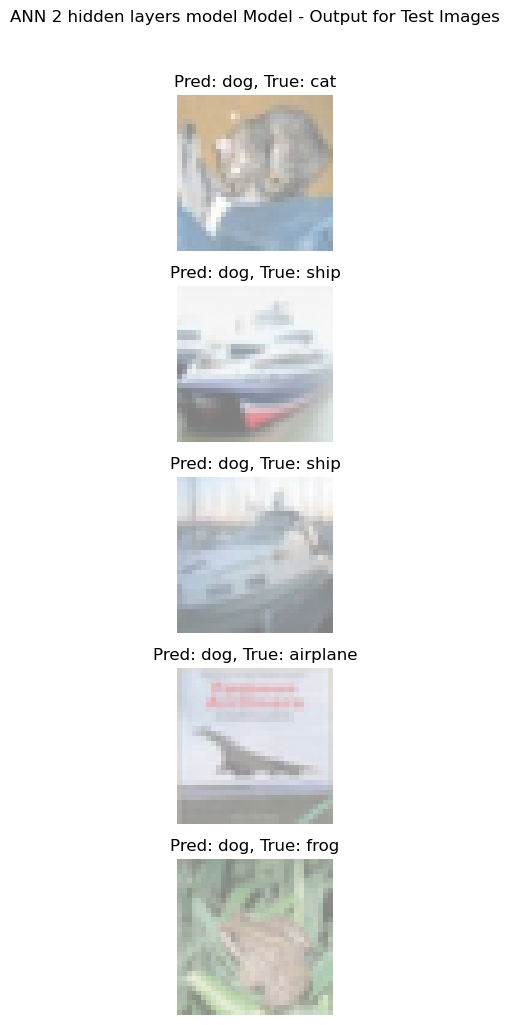

In [151]:
visualize_output(model0,'ANN 2 hidden layers model brfore                                                                                                                       ')

In [152]:
history1 = [evaluate(model1, val_loader)]
history1

[{'val_loss': 2.3041791915893555, 'val_acc': 0.10119485855102539}]

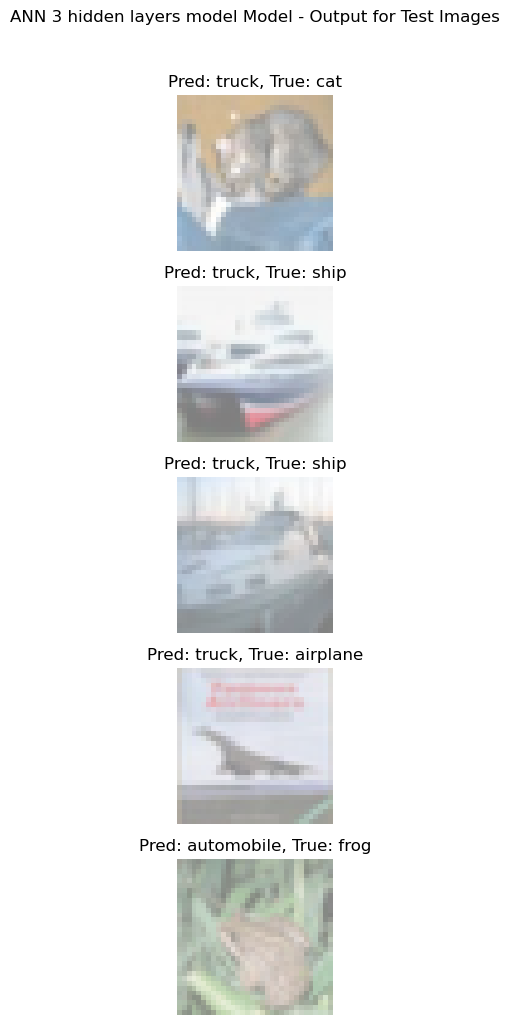

In [153]:
visualize_output(model1,'ANN 3 hidden layers model before')

In [154]:
history2 = [evaluate(model2, val_loader)]
history2

[{'val_loss': 2.3041210174560547, 'val_acc': 0.1067095547914505}]

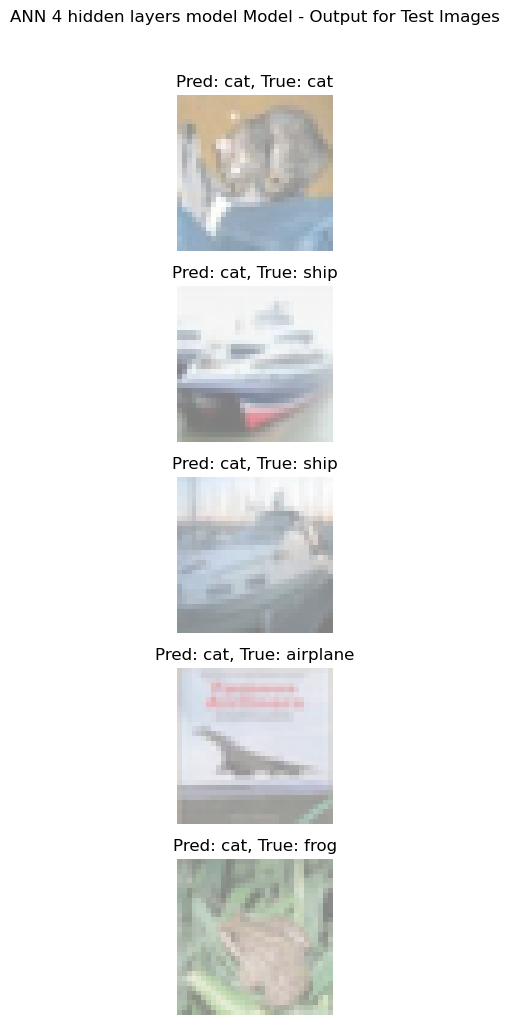

In [155]:
visualize_output(model2,'ANN 4 hidden layers model before')

In [156]:
history0 += fit(10, 1e-1, model0, train_loader, val_loader)

Epoch [0], val_loss: 1.9322, val_acc: 0.2971
Epoch [1], val_loss: 1.7642, val_acc: 0.3756
Epoch [2], val_loss: 1.6947, val_acc: 0.3945
Epoch [3], val_loss: 1.7102, val_acc: 0.3919
Epoch [4], val_loss: 1.8323, val_acc: 0.3646
Epoch [5], val_loss: 1.5804, val_acc: 0.4391
Epoch [6], val_loss: 1.6796, val_acc: 0.4174
Epoch [7], val_loss: 1.5926, val_acc: 0.4239
Epoch [8], val_loss: 1.4994, val_acc: 0.4621
Epoch [9], val_loss: 1.5820, val_acc: 0.4396


Here we notice accuracy is still increasing so we will increase the epoch and decrease the lr

In [157]:
history0 += fit(10, 1e-2, model0, train_loader, val_loader)

Epoch [0], val_loss: 1.4227, val_acc: 0.4915
Epoch [1], val_loss: 1.4157, val_acc: 0.4966
Epoch [2], val_loss: 1.4130, val_acc: 0.4984
Epoch [3], val_loss: 1.4089, val_acc: 0.4967
Epoch [4], val_loss: 1.4126, val_acc: 0.4966
Epoch [5], val_loss: 1.4041, val_acc: 0.5021
Epoch [6], val_loss: 1.4014, val_acc: 0.5013
Epoch [7], val_loss: 1.4064, val_acc: 0.4992
Epoch [8], val_loss: 1.4000, val_acc: 0.5027
Epoch [9], val_loss: 1.3962, val_acc: 0.5056


In [158]:
history0 += fit(10, 1e-3, model0, train_loader, val_loader)

Epoch [0], val_loss: 1.3885, val_acc: 0.5070
Epoch [1], val_loss: 1.3881, val_acc: 0.5060
Epoch [2], val_loss: 1.3872, val_acc: 0.5068
Epoch [3], val_loss: 1.3874, val_acc: 0.5076
Epoch [4], val_loss: 1.3871, val_acc: 0.5080
Epoch [5], val_loss: 1.3860, val_acc: 0.5101
Epoch [6], val_loss: 1.3864, val_acc: 0.5084
Epoch [7], val_loss: 1.3862, val_acc: 0.5080
Epoch [8], val_loss: 1.3862, val_acc: 0.5072
Epoch [9], val_loss: 1.3856, val_acc: 0.5080


In [159]:
history0 += fit(10, 1e-4, model0, train_loader, val_loader)

Epoch [0], val_loss: 1.3854, val_acc: 0.5072
Epoch [1], val_loss: 1.3853, val_acc: 0.5084
Epoch [2], val_loss: 1.3852, val_acc: 0.5078
Epoch [3], val_loss: 1.3853, val_acc: 0.5078
Epoch [4], val_loss: 1.3852, val_acc: 0.5080
Epoch [5], val_loss: 1.3852, val_acc: 0.5091
Epoch [6], val_loss: 1.3851, val_acc: 0.5082
Epoch [7], val_loss: 1.3851, val_acc: 0.5087
Epoch [8], val_loss: 1.3851, val_acc: 0.5089
Epoch [9], val_loss: 1.3850, val_acc: 0.5085


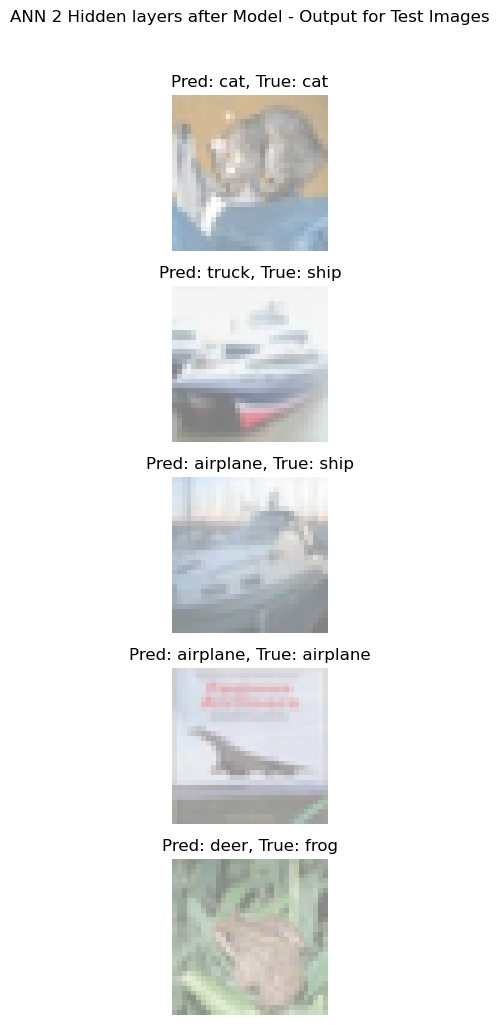

In [160]:
visualize_output(model0,'ANN 2 Hidden layers after')

In [161]:
history1 += fit(10, 1e-1, model1, train_loader, val_loader)

Epoch [0], val_loss: 2.0805, val_acc: 0.2699
Epoch [1], val_loss: 1.7468, val_acc: 0.3818
Epoch [2], val_loss: 1.6839, val_acc: 0.3934
Epoch [3], val_loss: 1.6223, val_acc: 0.4268
Epoch [4], val_loss: 1.5838, val_acc: 0.4413
Epoch [5], val_loss: 1.5224, val_acc: 0.4558
Epoch [6], val_loss: 1.5541, val_acc: 0.4516
Epoch [7], val_loss: 1.5780, val_acc: 0.4355
Epoch [8], val_loss: 1.4782, val_acc: 0.4698
Epoch [9], val_loss: 1.5262, val_acc: 0.4574


In [162]:
history1 += fit(10, 1e-2, model1, train_loader, val_loader)

Epoch [0], val_loss: 1.3572, val_acc: 0.5155
Epoch [1], val_loss: 1.3531, val_acc: 0.5190
Epoch [2], val_loss: 1.3580, val_acc: 0.5169
Epoch [3], val_loss: 1.3449, val_acc: 0.5232
Epoch [4], val_loss: 1.3369, val_acc: 0.5231
Epoch [5], val_loss: 1.3309, val_acc: 0.5248
Epoch [6], val_loss: 1.3321, val_acc: 0.5266
Epoch [7], val_loss: 1.3302, val_acc: 0.5274
Epoch [8], val_loss: 1.3247, val_acc: 0.5286
Epoch [9], val_loss: 1.3267, val_acc: 0.5318


In [163]:
history1 += fit(10, 1e-3, model1, train_loader, val_loader)

Epoch [0], val_loss: 1.3124, val_acc: 0.5348
Epoch [1], val_loss: 1.3107, val_acc: 0.5365
Epoch [2], val_loss: 1.3109, val_acc: 0.5352
Epoch [3], val_loss: 1.3112, val_acc: 0.5369
Epoch [4], val_loss: 1.3098, val_acc: 0.5363
Epoch [5], val_loss: 1.3107, val_acc: 0.5346
Epoch [6], val_loss: 1.3110, val_acc: 0.5354
Epoch [7], val_loss: 1.3085, val_acc: 0.5346
Epoch [8], val_loss: 1.3085, val_acc: 0.5363
Epoch [9], val_loss: 1.3088, val_acc: 0.5358


In [164]:
history1 += fit(10, 1e-4, model1, train_loader, val_loader)

Epoch [0], val_loss: 1.3080, val_acc: 0.5355
Epoch [1], val_loss: 1.3078, val_acc: 0.5363
Epoch [2], val_loss: 1.3077, val_acc: 0.5361
Epoch [3], val_loss: 1.3077, val_acc: 0.5365
Epoch [4], val_loss: 1.3077, val_acc: 0.5359
Epoch [5], val_loss: 1.3076, val_acc: 0.5369
Epoch [6], val_loss: 1.3075, val_acc: 0.5363
Epoch [7], val_loss: 1.3075, val_acc: 0.5369
Epoch [8], val_loss: 1.3075, val_acc: 0.5367
Epoch [9], val_loss: 1.3075, val_acc: 0.5365


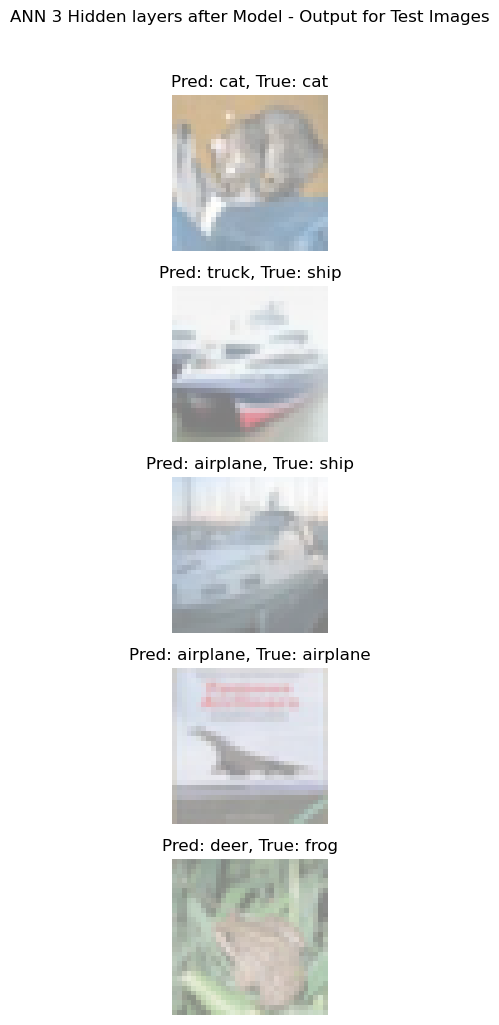

In [165]:
visualize_output(model1,'ANN 3 Hidden layers after')

In [166]:
history2 += fit(10, 1e-1, model2, train_loader, val_loader)

Epoch [0], val_loss: 2.0118, val_acc: 0.2420
Epoch [1], val_loss: 1.9096, val_acc: 0.2923
Epoch [2], val_loss: 1.9627, val_acc: 0.2953
Epoch [3], val_loss: 1.7114, val_acc: 0.3820
Epoch [4], val_loss: 1.7137, val_acc: 0.3928
Epoch [5], val_loss: 1.6497, val_acc: 0.3996
Epoch [6], val_loss: 1.6123, val_acc: 0.4205
Epoch [7], val_loss: 1.6764, val_acc: 0.3934
Epoch [8], val_loss: 1.6582, val_acc: 0.3945
Epoch [9], val_loss: 1.6911, val_acc: 0.4098


In [167]:
history2 += fit(10, 1e-2, model2, train_loader, val_loader)

Epoch [0], val_loss: 1.4434, val_acc: 0.4861
Epoch [1], val_loss: 1.4391, val_acc: 0.4872
Epoch [2], val_loss: 1.4330, val_acc: 0.4909
Epoch [3], val_loss: 1.4288, val_acc: 0.4906
Epoch [4], val_loss: 1.4304, val_acc: 0.4940
Epoch [5], val_loss: 1.4218, val_acc: 0.4902
Epoch [6], val_loss: 1.4235, val_acc: 0.4907
Epoch [7], val_loss: 1.4203, val_acc: 0.4900
Epoch [8], val_loss: 1.4109, val_acc: 0.4984
Epoch [9], val_loss: 1.4094, val_acc: 0.4985


In [168]:
history2 += fit(10, 1e-3, model2, train_loader, val_loader)

Epoch [0], val_loss: 1.3969, val_acc: 0.5061
Epoch [1], val_loss: 1.3949, val_acc: 0.5080
Epoch [2], val_loss: 1.3940, val_acc: 0.5055
Epoch [3], val_loss: 1.3930, val_acc: 0.5073
Epoch [4], val_loss: 1.3926, val_acc: 0.5069
Epoch [5], val_loss: 1.3925, val_acc: 0.5086
Epoch [6], val_loss: 1.3930, val_acc: 0.5069
Epoch [7], val_loss: 1.3918, val_acc: 0.5082
Epoch [8], val_loss: 1.3914, val_acc: 0.5078
Epoch [9], val_loss: 1.3911, val_acc: 0.5075


In [169]:
history2 += fit(10, 1e-4, model2, train_loader, val_loader)

Epoch [0], val_loss: 1.3906, val_acc: 0.5080
Epoch [1], val_loss: 1.3906, val_acc: 0.5073
Epoch [2], val_loss: 1.3904, val_acc: 0.5067
Epoch [3], val_loss: 1.3904, val_acc: 0.5069
Epoch [4], val_loss: 1.3904, val_acc: 0.5073
Epoch [5], val_loss: 1.3903, val_acc: 0.5067
Epoch [6], val_loss: 1.3902, val_acc: 0.5075
Epoch [7], val_loss: 1.3902, val_acc: 0.5073
Epoch [8], val_loss: 1.3902, val_acc: 0.5080
Epoch [9], val_loss: 1.3901, val_acc: 0.5071


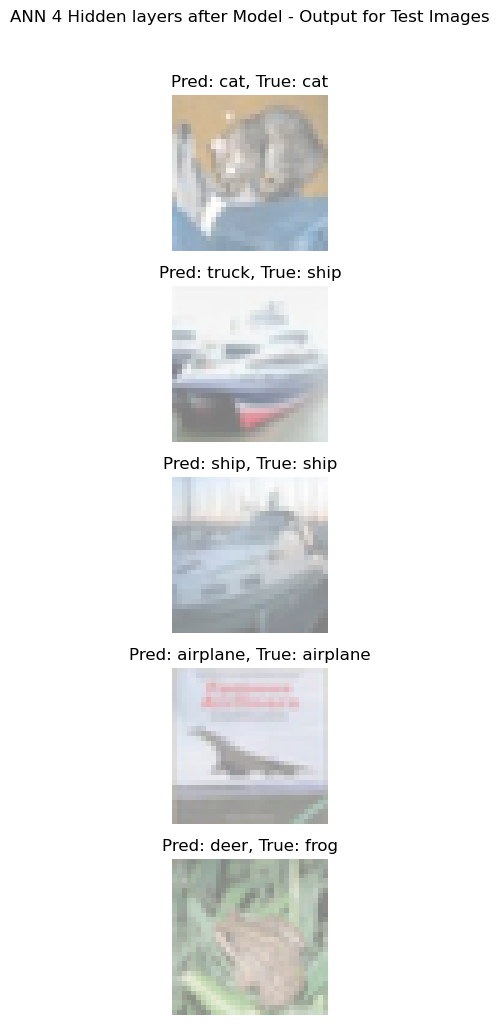

In [226]:
visualize_output(model2,'ANN 4 Hidden layers after')

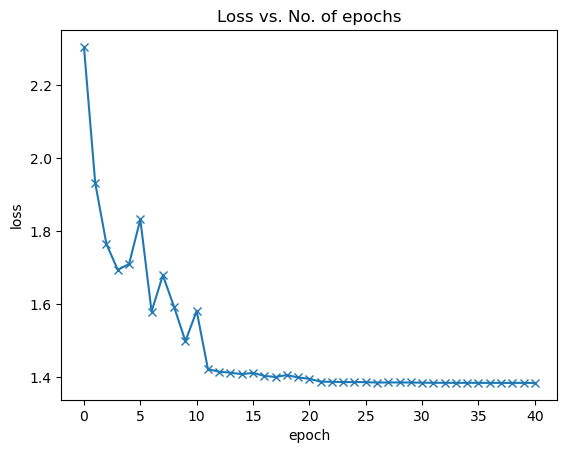

In [171]:
plot_losses(history0)

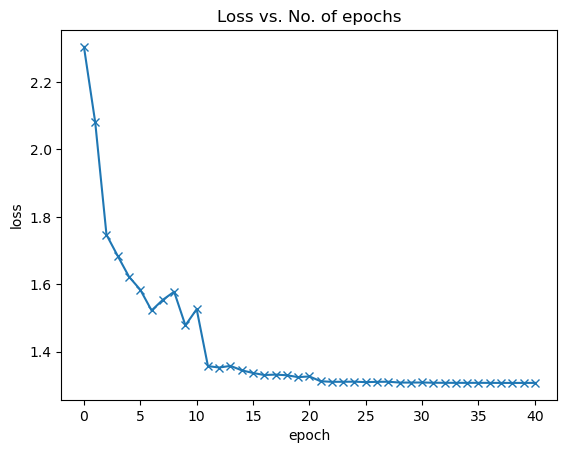

In [172]:
plot_losses(history1)

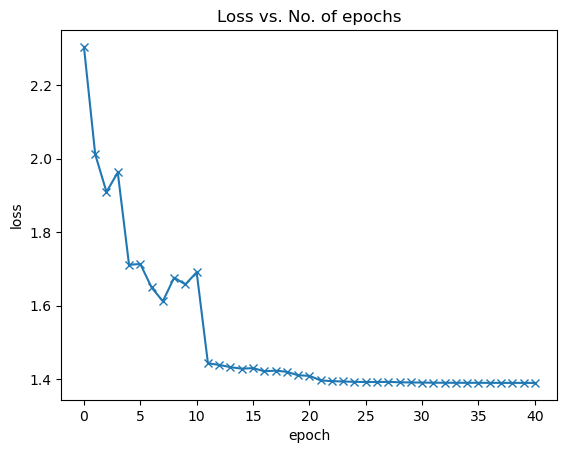

In [173]:
plot_losses(history2)

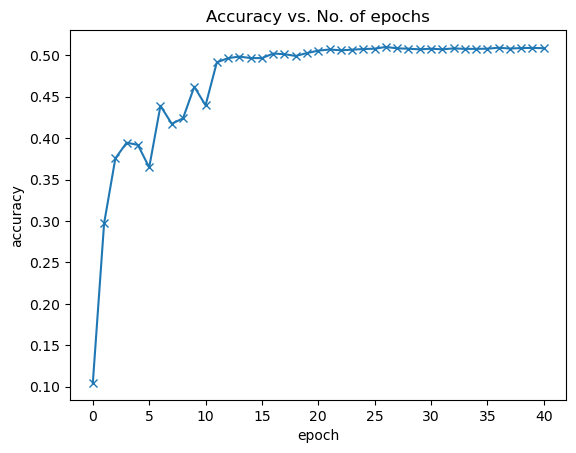

In [174]:
plot_accuracies(history0)

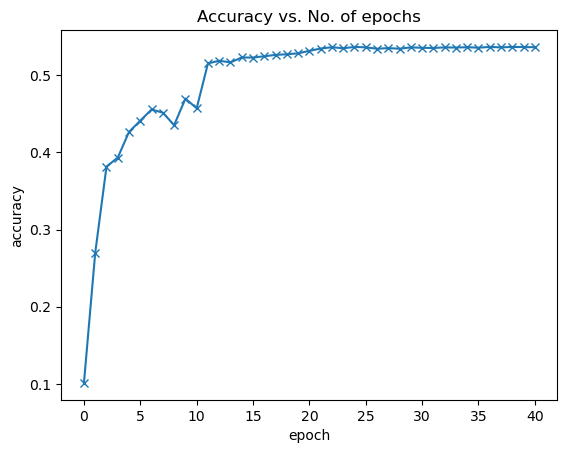

In [175]:
plot_accuracies(history1)

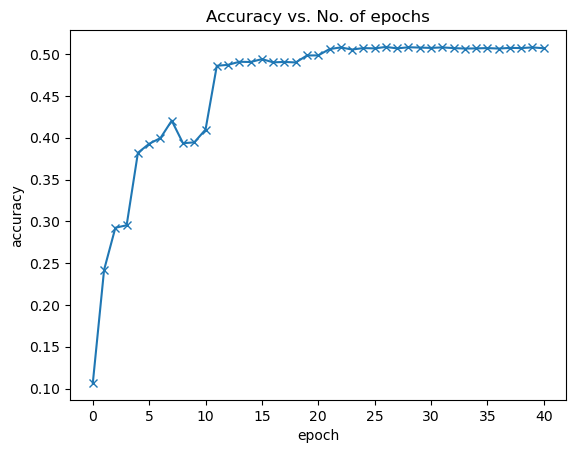

In [176]:
plot_accuracies(history2)

In [214]:
evaluate(model0, test_loader)

{'val_loss': 1.228731632232666, 'val_acc': 0.5645887851715088}

In [178]:
evaluate(model1, test_loader)

{'val_loss': 1.259592890739441, 'val_acc': 0.5523437261581421}

In [179]:
evaluate(model2, test_loader)

{'val_loss': 1.3492356538772583, 'val_acc': 0.5146484375}

# Confusion matrix

In [180]:
def get_pred(model, loader):
    model.eval()
    device = get_default_device()
    model.to(device)

    pred = torch.tensor([]).to(device)
    targets = torch.tensor([]).to(device)

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():
            y_pred = model(x)
            y_pred = torch.argmax(y_pred, dim=1)

            pred = torch.cat((pred, y_pred), 0)
            targets = torch.cat((targets, y), 0)

    return np.array(pred.cpu()), np.array(targets.cpu())

In [181]:
pred0, target0 = get_pred(model0, test_loader)

In [182]:
pred1, target1 = get_pred(model1, test_loader)

In [183]:
pred2, target2 = get_pred(model2, test_loader)

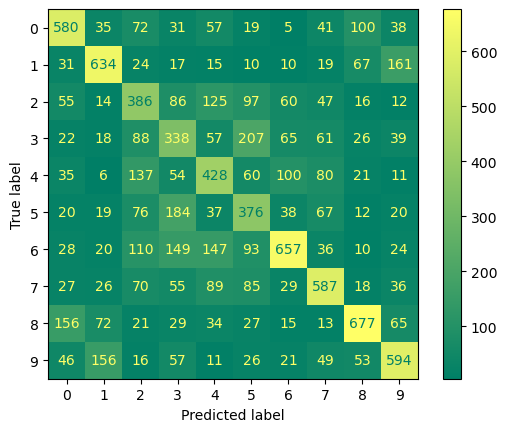

In [184]:
conf = confusion_matrix(pred0, target0)
cm = ConfusionMatrixDisplay(conf)
cm.plot(cmap="summer")

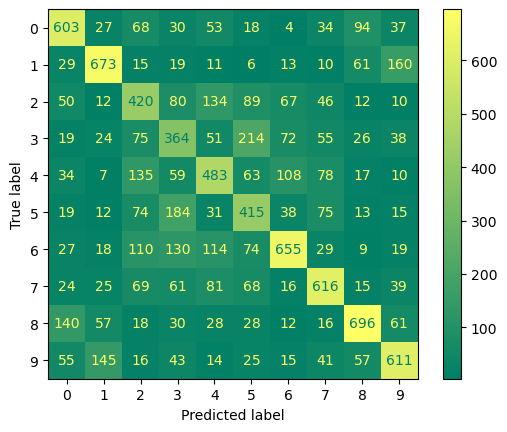

In [185]:
conf = confusion_matrix(pred1, target1)
cm = ConfusionMatrixDisplay(conf)
cm.plot(cmap="summer")

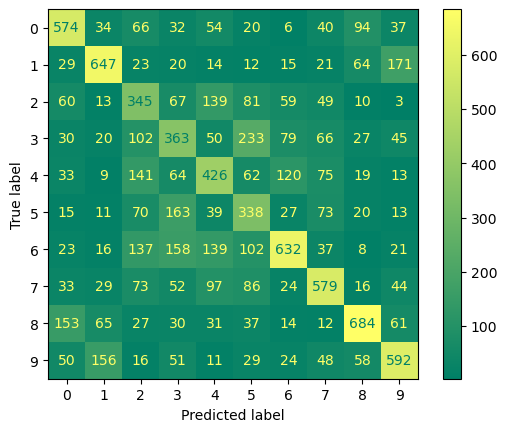

In [186]:
conf = confusion_matrix(pred2, target2)
cm = ConfusionMatrixDisplay(conf)
cm.plot(cmap="summer")

# Transfer Learning

In [187]:
vgg = models.vgg16(weights = "VGG16_Weights.DEFAULT").to(device)
resnet = models.resnet50(weights="ResNet50_Weights.DEFAULT").to(device)
googlenet = models.googlenet(weights="GoogLeNet_Weights.DEFAULT").to(device)

we have to train these models

In [188]:
def get_accuracy(model, loader):
    model.eval()
    model.to(device)

    total_samples = 0
    total_hits = 0

    for x, y in loader:

        # stack the RGB values together
        y = y.to(device)
        x = x.to(device)

        with torch.no_grad():
            pred = model(x)
            pred = torch.argmax(pred, dim=1)
            total_hits += torch.sum(pred == y).item()
            total_samples += y.shape[0]

    return total_hits/total_samples

In [189]:
def train(model, epochs, lr, loss_fun, loss_history, accuracy_history, opt_func=torch.optim.SGD):
  model.train()
  device =get_default_device()
  model.to(device)
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    
    for ind, (data, targets) in enumerate(train_loader):

      data = data.to(device)
      targets = targets.to(device)

      pred = model(data)
      loss = loss_fun(pred, targets)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    acc = get_accuracy(model, test_loader, vector=False)
    print("Epoch [{}], train_loss: {}, test_acc: {}".format(epoch, loss.item(), acc))
    accuracy_history.append(acc)
    loss_history.append(loss.item())


In [190]:
# modify the last node to classify 10 classes
in_feat = vgg.classifier[-1].in_features
vgg.classifier[-1] = nn.Linear(in_feat, 10)
loss_function = nn.CrossEntropyLoss()
vgg_loss = []
vgg_acc = []

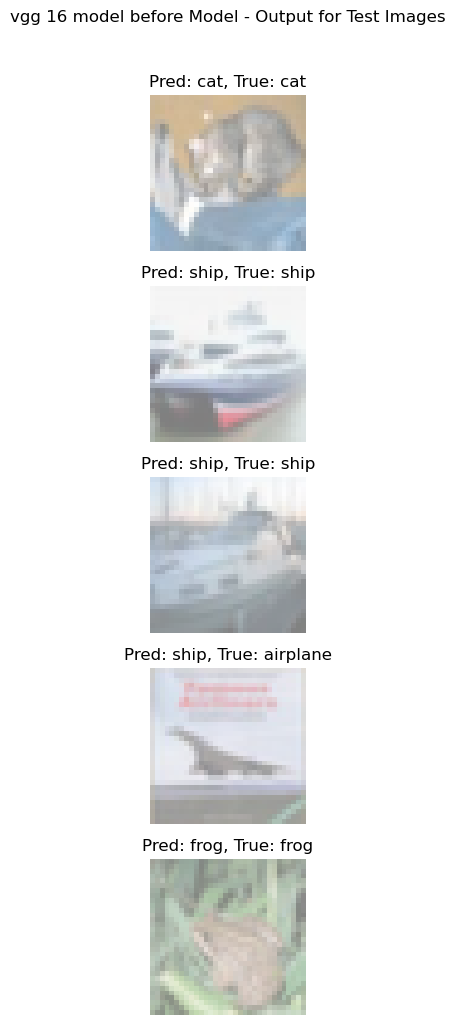

In [211]:
visualize_output(vgg,'vgg 16 model before')

In [191]:
history = train(vgg, 10, 1e-3, loss_function, vgg_loss, vgg_acc)

Epoch [0], train_loss: 1.0917882919311523, test_acc: 0.631
Epoch [1], train_loss: 0.9805405139923096, test_acc: 0.7097
Epoch [2], train_loss: 0.640265703201294, test_acc: 0.7345
Epoch [3], train_loss: 0.701623260974884, test_acc: 0.7525
Epoch [4], train_loss: 0.5076039433479309, test_acc: 0.7703
Epoch [5], train_loss: 0.49739402532577515, test_acc: 0.7773
Epoch [6], train_loss: 0.528486967086792, test_acc: 0.7878
Epoch [7], train_loss: 0.5893827676773071, test_acc: 0.7961
Epoch [8], train_loss: 0.42036598920822144, test_acc: 0.8003
Epoch [9], train_loss: 0.3718511760234833, test_acc: 0.7958


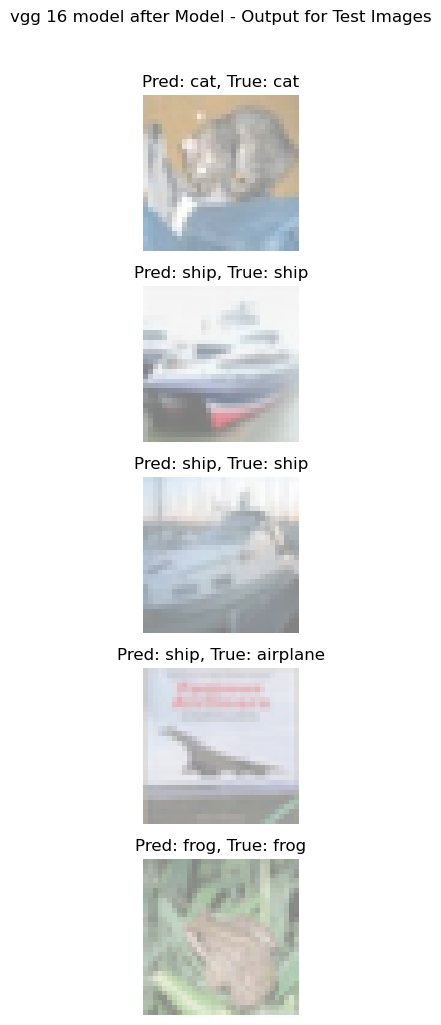

In [192]:
visualize_output(vgg,'vgg 16 model after')

In [193]:
get_accuracy(vgg, test_loader)

0.7958

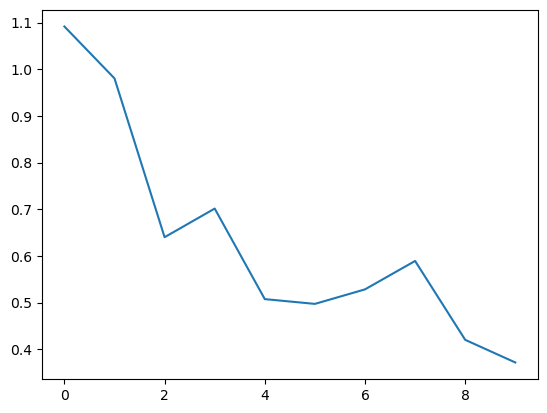

In [194]:
plt.plot(vgg_loss)

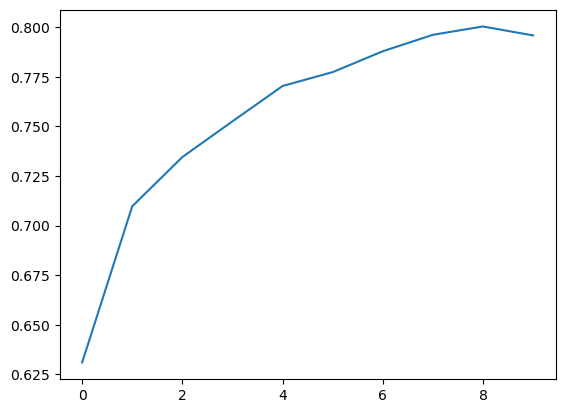

In [195]:
plt.plot(vgg_acc)

In [196]:
in_feat = resnet.fc.in_features
resnet.fc = nn.Linear(in_feat, 10)
loss_function = nn.CrossEntropyLoss()
resnet_loss = []
resnet_acc = []

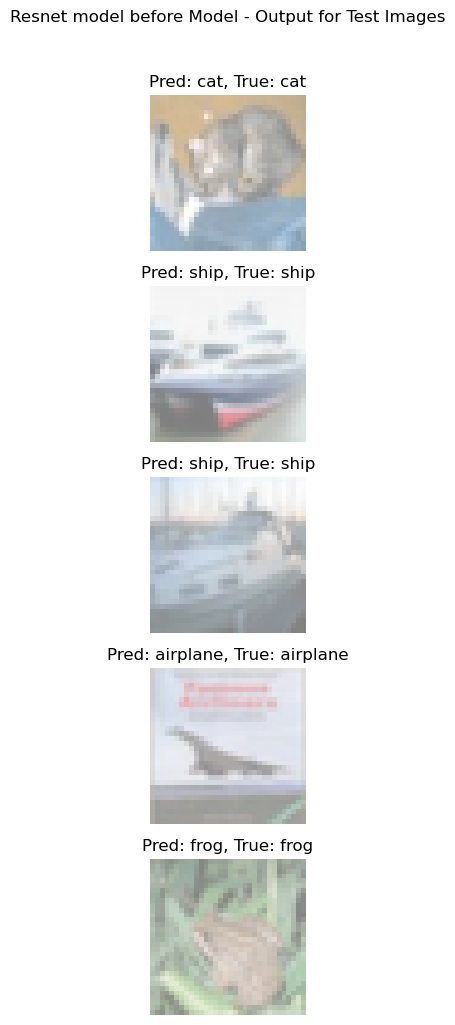

In [212]:
visualize_output(resnet,'Resnet model before')

In [197]:
history = train(resnet, 10, 1e-3, loss_function, resnet_loss, resnet_acc)

Epoch [0], train_loss: 2.2460169792175293, test_acc: 0.1779
Epoch [1], train_loss: 0.7965223789215088, test_acc: 0.6851
Epoch [2], train_loss: 0.5620636940002441, test_acc: 0.7563
Epoch [3], train_loss: 0.6067141890525818, test_acc: 0.7827
Epoch [4], train_loss: 0.6188839077949524, test_acc: 0.7995
Epoch [5], train_loss: 0.4274680018424988, test_acc: 0.8047
Epoch [6], train_loss: 0.26591795682907104, test_acc: 0.8041
Epoch [7], train_loss: 0.31125736236572266, test_acc: 0.8118
Epoch [8], train_loss: 0.15658776462078094, test_acc: 0.8212
Epoch [9], train_loss: 0.47877153754234314, test_acc: 0.8176


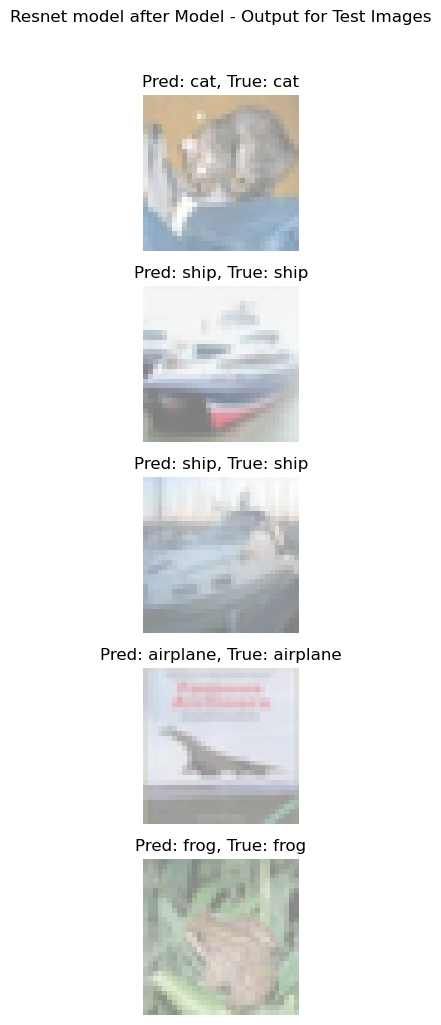

In [198]:
visualize_output(resnet,'Resnet model after')

In [199]:
get_accuracy(resnet, test_loader)

0.8176

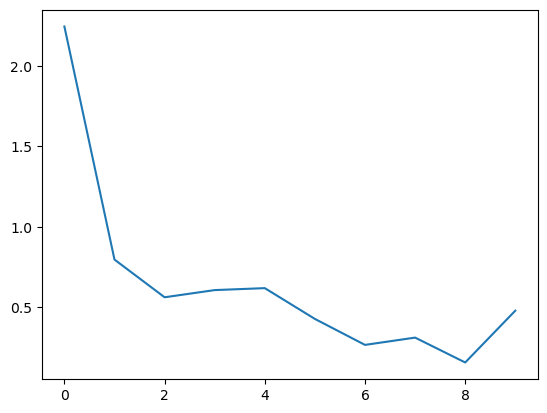

In [200]:
plt.plot(resnet_loss)

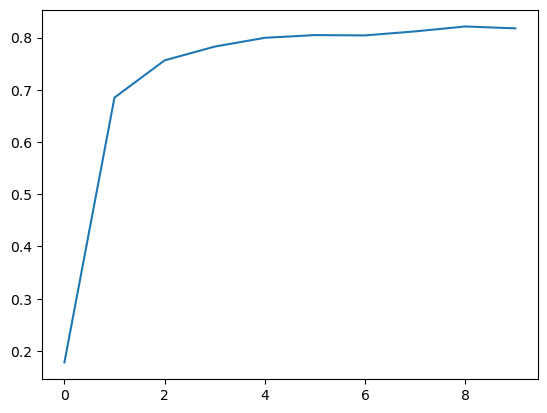

In [201]:
plt.plot(resnet_acc)

In [202]:
in_ft = googlenet.fc.in_features
googlenet.fc = nn.Linear(in_ft, 10)
loss_function = nn.CrossEntropyLoss()
googlenet_loss = []
googlenet_acc = []

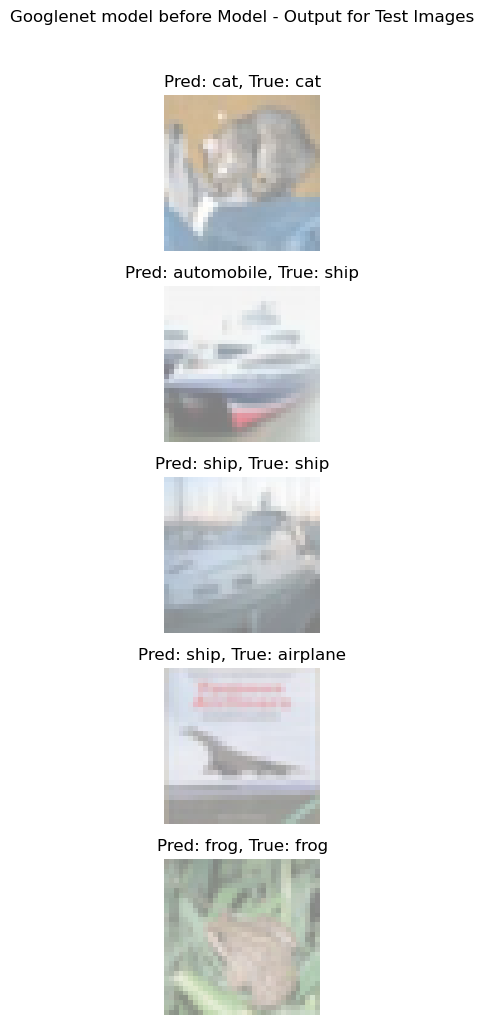

In [213]:
visualize_output(googlenet,'Googlenet model before')

In [203]:
history = train(googlenet, 10, 1e-3, loss_function, googlenet_loss, googlenet_acc)

Epoch [0], train_loss: 2.195570945739746, test_acc: 0.202
Epoch [1], train_loss: 1.4754902124404907, test_acc: 0.5024
Epoch [2], train_loss: 0.917975127696991, test_acc: 0.5891
Epoch [3], train_loss: 0.8245214223861694, test_acc: 0.6292
Epoch [4], train_loss: 0.7304926514625549, test_acc: 0.6471
Epoch [5], train_loss: 0.8703005313873291, test_acc: 0.6625
Epoch [6], train_loss: 0.7538110017776489, test_acc: 0.6781
Epoch [7], train_loss: 0.8478937745094299, test_acc: 0.6867
Epoch [8], train_loss: 0.6850879788398743, test_acc: 0.6889
Epoch [9], train_loss: 0.4796377420425415, test_acc: 0.6888


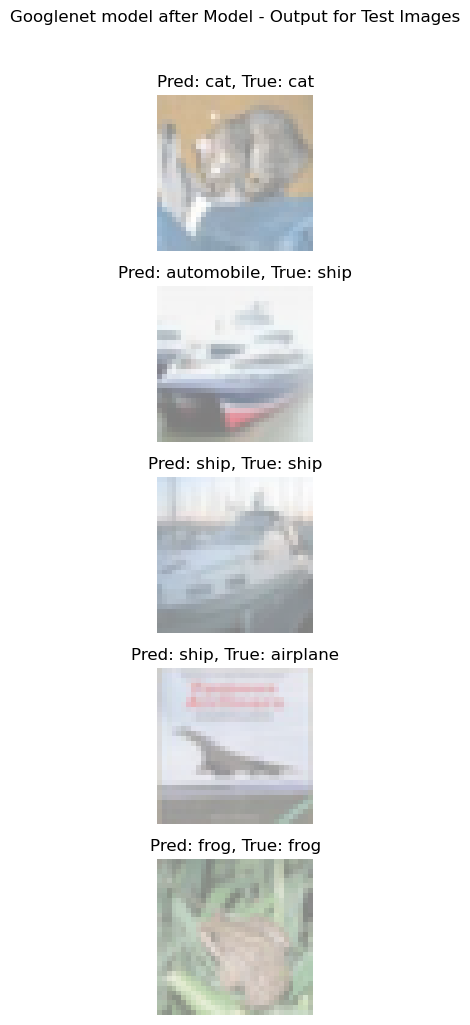

In [204]:
visualize_output(googlenet,'Googlenet model after')

In [215]:
get_accuracy(googlenet, test_loader)

0.6888

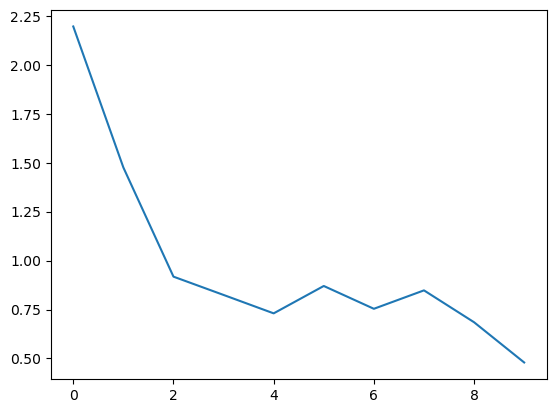

In [206]:
plt.plot(googlenet_loss)

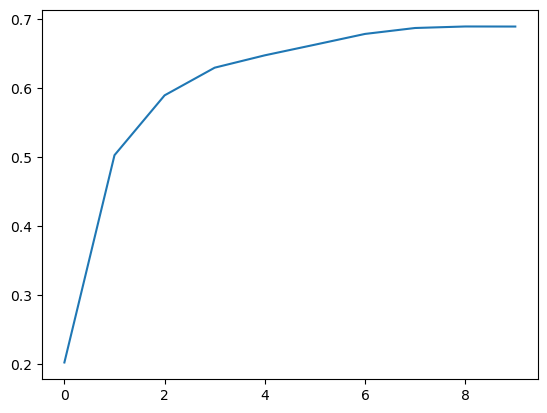

In [207]:
plt.plot(googlenet_acc)

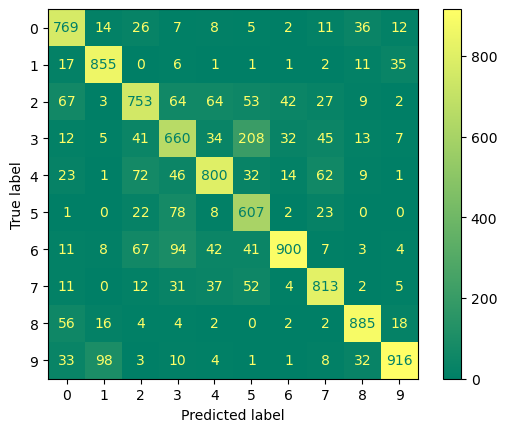

In [208]:
vgg_pred, vgg_targets = get_pred(vgg, test_loader)
vgg_conf = confusion_matrix(torch.tensor(vgg_pred).cpu(), torch.tensor(vgg_targets).cpu())
cm = ConfusionMatrixDisplay(vgg_conf)
cm.plot( cmap="summer")

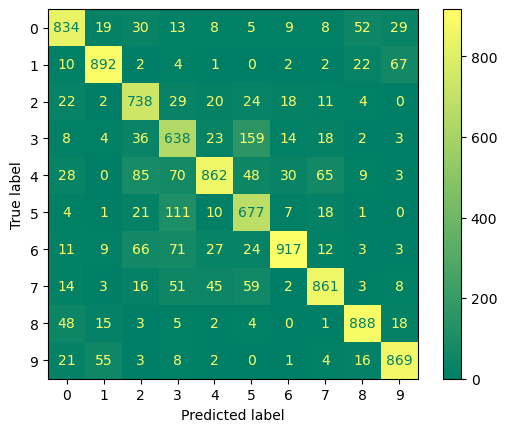

In [209]:
resnet_pred, resnet_targets = get_pred(resnet, test_loader)
resnet_conf = confusion_matrix(torch.tensor(resnet_pred).cpu(), torch.tensor(resnet_targets).cpu())
cm = ConfusionMatrixDisplay(resnet_conf)
cm.plot( cmap="summer")

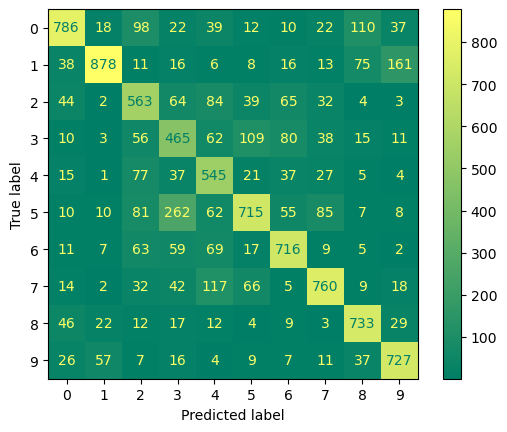

In [210]:
googlenet_pred, googlenet_targets = get_pred(googlenet, test_loader)
googlenet_conf = confusion_matrix(torch.tensor(googlenet_pred).cpu(), torch.tensor(googlenet_targets).cpu())
cm = ConfusionMatrixDisplay(googlenet_conf)
cm.plot( cmap="summer")